In [1]:
import pandas as pd
import numpy as np
import pyreadstat
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.inspection import PartialDependenceDisplay
import statsmodels.formula.api as smf


In [2]:
# --- 1. 데이터 로딩 및 선택 ---
# PISA 2015 데이터 로드
alldata15, meta15 = pyreadstat.read_sav("data/DEU_CY6_MS_CMB_STU_QQQ.sav")
DEUdata15 = alldata15[alldata15['CNT'] == 'DEU'].copy()
del alldata15

# PISA 2018 데이터 로드
alldata18, meta18 = pyreadstat.read_sav("data/DEU_CY07_MSU_STU_QQQ.sav")
DEUdata18 = alldata18[alldata18['CNT'] == 'DEU'].copy()
del alldata18

In [7]:
# 변수 선택
cols15 = [
    "CNTSCHID", "ST004D01T", "ESCS", "INTICT", "COMPICT", "AUTICT", "SOIAICT"
] + [col for col in DEUdata15.columns if col.startswith('PV') and col.endswith('MATH')] \
  + [col for col in DEUdata15.columns if col.startswith('PV') and col.endswith('SCIE')] \
  + [col for col in DEUdata15.columns if col.startswith('W_FS')]
dataA15 = DEUdata15[cols15].copy()

cols18 = [
    "CNTSCHID", "ST004D01T", "ESCS", "ICTHOME", "ICTSCH", "AUTICT", "SOIAICT"
] + [col for col in DEUdata18.columns if col.startswith('PV') and col.endswith('MATH')] \
  + [col for col in DEUdata18.columns if col.startswith('PV') and col.endswith('SCIE')] \
  + [col for col in DEUdata18.columns if col.startswith('W_FS')]
dataA18 = DEUdata18[cols18].copy()

In [8]:
# --- 2. 변수명 변경 및 전처리 ---
# 2015 데이터
dataA15 = dataA15.rename(columns={'ST004D01T': 'Gender'})
dataA15['Gender'] = dataA15['Gender'].replace({1: 'F', 2: 'M'})
dataA15['Gender'] = dataA15['Gender'].astype('category')

# 2018 데이터
dataA18 = dataA18.rename(columns={'ST004D01T': 'Gender'})
dataA18['Gender'] = dataA18['Gender'].replace({1: 'F', 2: 'M'})
dataA18['Gender'] = dataA18['Gender'].astype('category')

In [9]:
# PV(Plausible Values) 변수들의 평균 계산
pv_math_cols15 = [col for col in dataA15.columns if col.startswith('PV') and col.endswith('MATH')]
pv_scie_cols15 = [col for col in dataA15.columns if col.startswith('PV') and col.endswith('SCIE')]
dataA15['PV_MATH'] = dataA15[pv_math_cols15].mean(axis=1)
dataA15['PV_SCIE'] = dataA15[pv_scie_cols15].mean(axis=1)

pv_math_cols18 = [col for col in dataA18.columns if col.startswith('PV') and col.endswith('MATH')]
pv_scie_cols18 = [col for col in dataA18.columns if col.startswith('PV') and col.endswith('SCIE')]
dataA18['PV_MATH'] = dataA18[pv_math_cols18].mean(axis=1)
dataA18['PV_SCIE'] = dataA18[pv_scie_cols18].mean(axis=1)


In [10]:
# 가중치 변수 평균 계산
w_fstu_cols15 = [col for col in dataA15.columns if col.startswith('W_FS')]
dataA15['W_FSTU'] = dataA15[w_fstu_cols15].mean(axis=1)

w_fstu_cols18 = [col for col in dataA18.columns if col.startswith('W_FS')]
dataA18['W_FSTU'] = dataA18[w_fstu_cols18].mean(axis=1)


In [11]:
# 불필요한 PV 및 가중치 변수 제거
dataA15.drop(columns=pv_math_cols15 + pv_scie_cols15 + w_fstu_cols15, inplace=True)
dataA18.drop(columns=pv_math_cols18 + pv_scie_cols18 + w_fstu_cols18, inplace=True)


In [12]:

# --- 3. 결측치 처리 ---
# IterativeImputer를 사용한 결측치 대체
imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=10, random_state=100)


In [14]:

# 2015 데이터
data_imputed15 = dataA15.select_dtypes(include=np.number)
imputed_values15 = imputer.fit_transform(data_imputed15)
data_imputed15 = pd.DataFrame(imputed_values15, columns=data_imputed15.columns, index=data_imputed15.index)
dataA15[data_imputed15.columns] = data_imputed15


In [17]:
# 2018 데이터
data_imputed18 = dataA18.select_dtypes(include=np.number)
# 완전히 결측된 컬럼 제거
data_imputed18 = data_imputed18.dropna(axis=1, how='all')
# 결측치가 있는 컬럼만 선택 (imputer는 최소 하나의 유효값이 필요)
valid_cols = data_imputed18.columns[data_imputed18.notna().any()].tolist()
data_imputed18 = data_imputed18[valid_cols]

if len(valid_cols) > 0:
    imputed_values18 = imputer.fit_transform(data_imputed18)
    data_imputed18_new = pd.DataFrame(imputed_values18, columns=valid_cols, index=data_imputed18.index)
    dataA18[valid_cols] = data_imputed18_new
    print(f"2018 데이터 결측치 처리 완료. 처리된 컬럼: {len(valid_cols)}개")
else:
    print("2018 데이터에 처리할 수치형 컬럼이 없습니다.")

2018 데이터 결측치 처리 완료. 처리된 컬럼: 7개


In [20]:
# --- 4. 목표 변수 생성 ---
# 과학(Sc)과 수학(M)에 대한 상위/하위 25% 분류
# 2015
dataA15['Sc'] = pd.qcut(dataA15['PV_SCIE'], q=[0, 0.25, 0.75, 1], labels=['L', 'M', 'H']).cat.remove_categories('M')
dataA15['M'] = pd.qcut(dataA15['PV_MATH'], q=[0, 0.25, 0.75, 1], labels=['L', 'M', 'H']).cat.remove_categories('M')

# 2018
dataA18['Sc'] = pd.qcut(dataA18['PV_SCIE'], q=[0, 0.25, 0.75, 1], labels=['L', 'M', 'H']).cat.remove_categories('M')
dataA18['M'] = pd.qcut(dataA18['PV_MATH'], q=[0, 0.25, 0.75, 1], labels=['L', 'M', 'H']).cat.remove_categories('M')


In [21]:
# --- 5. 모델링을 위한 데이터 준비 ---
# 과학 모델 데이터
dataSc15 = dataA15.drop(columns=['PV_MATH', 'PV_SCIE', 'M']).dropna(subset=['Sc'])
# 수학 모델 데이터
dataM15 = dataA15.drop(columns=['PV_MATH', 'PV_SCIE', 'Sc']).dropna(subset=['M'])

# 특징(X)과 타겟(y) 분리
X_sc = dataSc15.drop(columns=['Sc', 'CNTSCHID', 'W_FSTU'])
y_sc = dataSc15['Sc']
X_m = dataM15.drop(columns=['M', 'CNTSCHID', 'W_FSTU'])
y_m = dataM15['M']


In [22]:
# 범주형 변수 더미화
X_sc = pd.get_dummies(X_sc, drop_first=True)
X_m = pd.get_dummies(X_m, drop_first=True)


In [23]:
# --- 6. 데이터 분할 및 오버샘플링 ---
# 과학
X_train_sc_u, X_test_sc, y_train_sc_u, y_test_sc = train_test_split(X_sc, y_sc, test_size=0.2, random_state=100, stratify=y_sc)
# 수학
X_train_m_u, X_test_m, y_train_m_u, y_test_m = train_test_split(X_m, y_m, test_size=0.2, random_state=100, stratify=y_m)


In [24]:
# RandomOverSampler를 사용한 오버샘플링
ros = RandomOverSampler(random_state=100)
X_train_sc, y_train_sc = ros.fit_resample(X_train_sc_u, y_train_sc_u)
X_train_m, y_train_m = ros.fit_resample(X_train_m_u, y_train_m_u)

print("Science Oversampled training set shape:", X_train_sc.shape)
print("Math Oversampled training set shape:", X_train_m.shape)


Science Oversampled training set shape: (2602, 6)
Math Oversampled training set shape: (2602, 6)


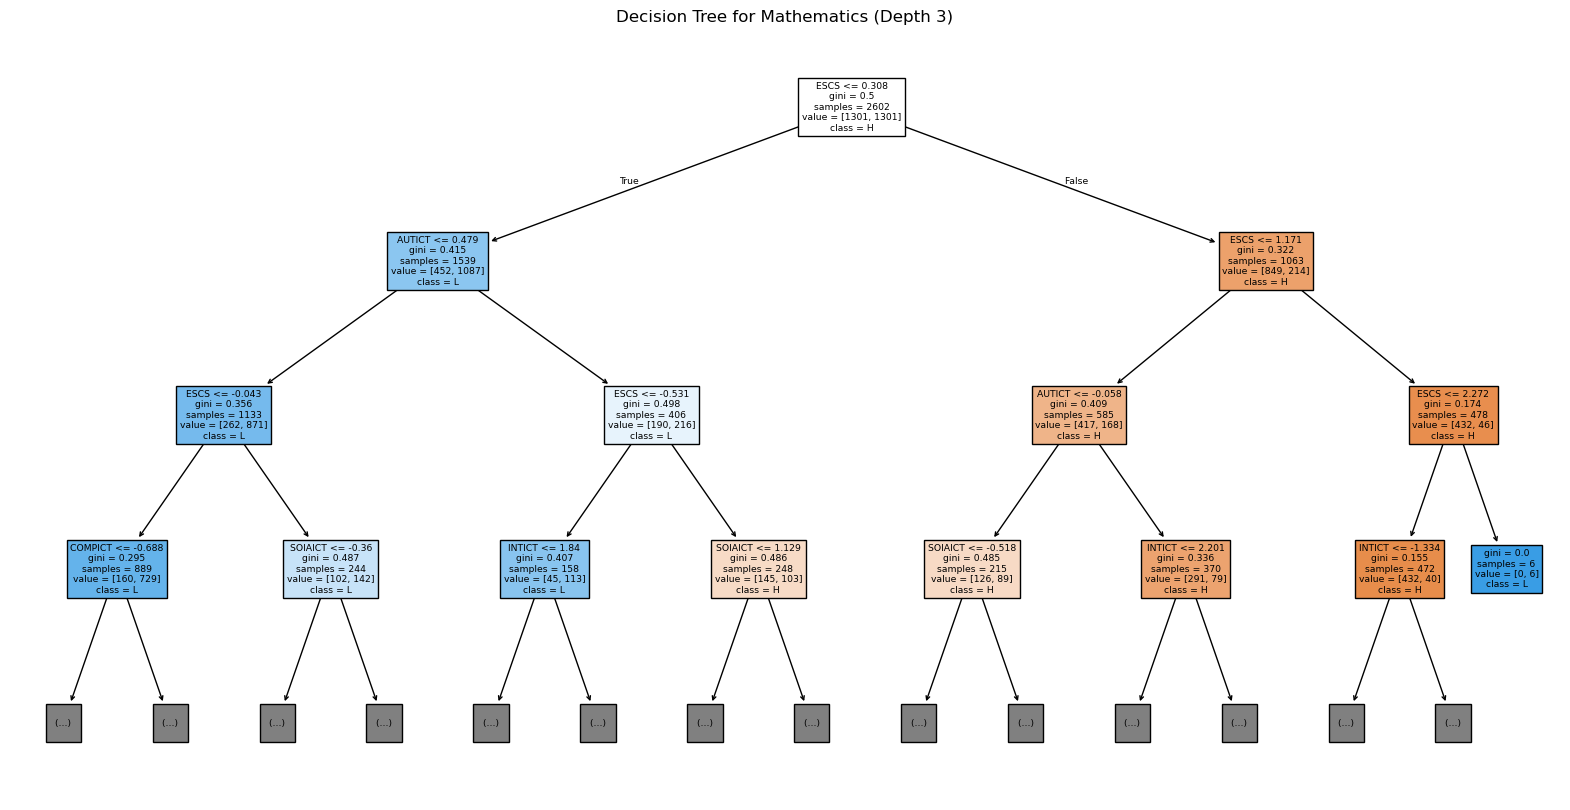

In [25]:
# --- 7. 모델링 및 평가 ---
# 결정 트리 (수학)
dt_m = DecisionTreeClassifier(random_state=100)
dt_m.fit(X_train_m, y_train_m)

plt.figure(figsize=(20, 10))
plot_tree(dt_m, feature_names=X_train_m.columns, class_names=dt_m.classes_, filled=True, max_depth=3)
plt.title("Decision Tree for Mathematics (Depth 3)")
plt.show()



In [26]:
# 랜덤 포레스트 (수학)
rf_m = RandomForestClassifier(n_estimators=100, random_state=100, oob_score=True)
rf_m.fit(X_train_m, y_train_m)



RandomForestClassifier(oob_score=True, random_state=100)

In [27]:
# OOB 점수
print(f"Random Forest OOB Score (Math): {rf_m.oob_score_:.4f}")



Random Forest OOB Score (Math): 0.7798


In [28]:
# 예측 및 정확도
y_pred_m = rf_m.predict(X_test_m)
print(f"Random Forest Accuracy (Math): {accuracy_score(y_test_m, y_pred_m):.4f}")


Random Forest Accuracy (Math): 0.7665


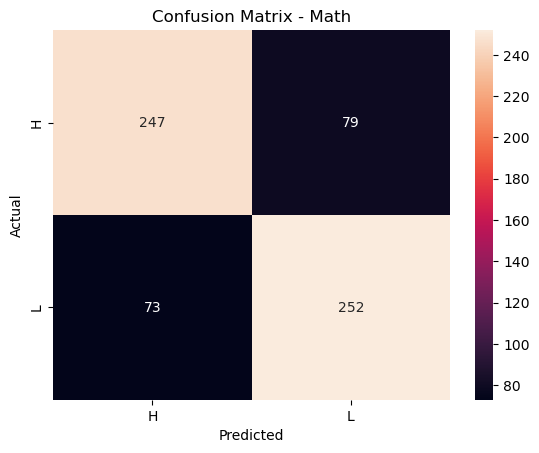

In [29]:
# 혼동 행렬
cm_m = confusion_matrix(y_test_m, y_pred_m)
sns.heatmap(cm_m, annot=True, fmt='d', xticklabels=rf_m.classes_, yticklabels=rf_m.classes_)
plt.title('Confusion Matrix - Math')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


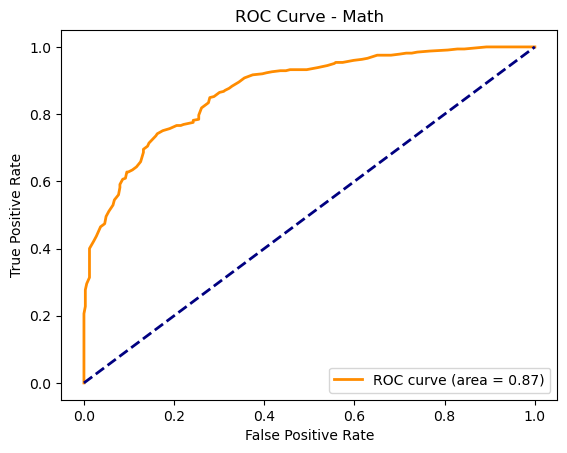

In [30]:
# ROC 커브
y_prob_m = rf_m.predict_proba(X_test_m)[:, 1]
fpr, tpr, _ = roc_curve(y_test_m, y_prob_m, pos_label=rf_m.classes_[1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Math')
plt.legend(loc="lower right")
plt.show()


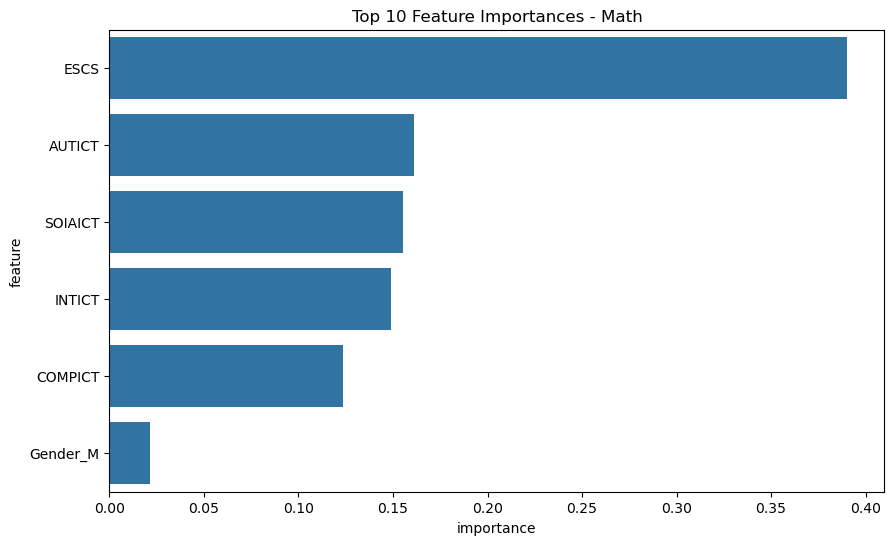

In [31]:
# 변수 중요도
importance_m = pd.DataFrame({'feature': X_train_m.columns, 'importance': rf_m.feature_importances_})
importance_m = importance_m.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_m)
plt.title('Top 10 Feature Importances - Math')
plt.show()


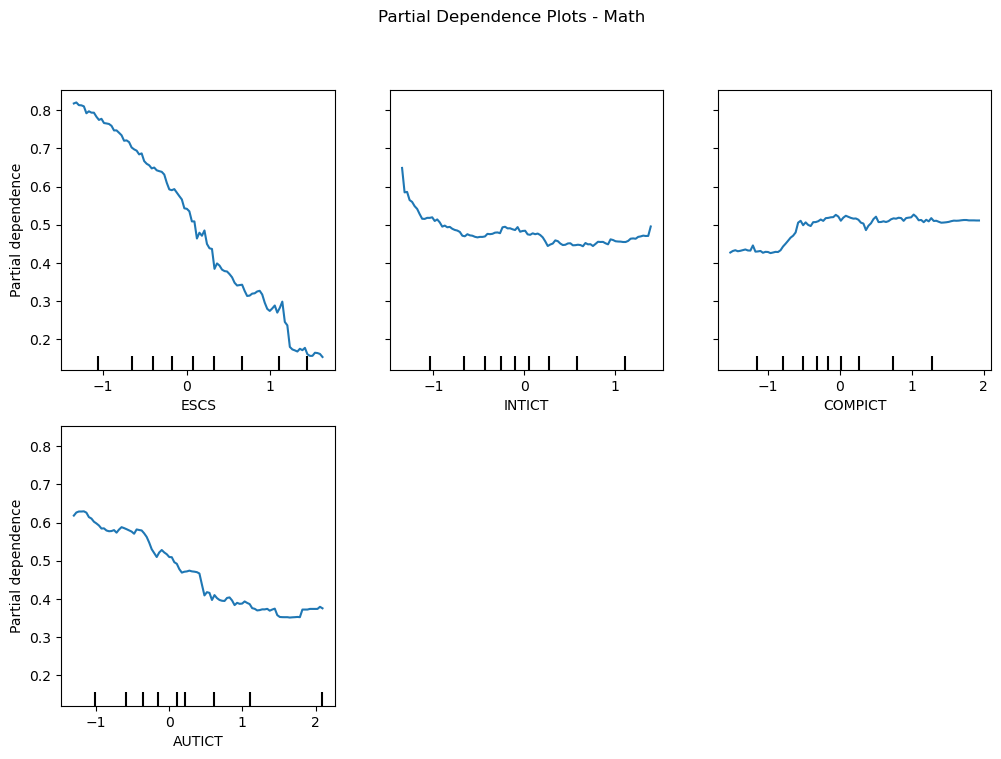

In [32]:
# 부분 의존성 플롯 (PDP)
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(rf_m, X_train_m, features=['ESCS', 'INTICT', 'COMPICT', 'AUTICT'], ax=ax)
plt.suptitle('Partial Dependence Plots - Math')
plt.show()



In [33]:
# --- 8. 다층 모델 (Multilevel Model) ---
# 다층 모델을 위한 데이터 준비
mlm_data = dataA15.copy()
mlm_data['CNTSCHID'] = mlm_data['CNTSCHID'].astype('category')


In [34]:
# 수학 모델
mixed_m = smf.mixedlm("PV_MATH ~ Gender + ESCS + INTICT + COMPICT + AUTICT + SOIAICT", 
                      data=mlm_data, groups=mlm_data["CNTSCHID"])
result_m = mixed_m.fit()
print("\n--- Multilevel Model Results (Mathematics) ---")
print(result_m.summary())



--- Multilevel Model Results (Mathematics) ---
           Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: PV_MATH    
No. Observations:   6504    Method:             REML       
No. Groups:         256     Scale:              3169.5467  
Min. group size:    2       Log-Likelihood:     -35842.4953
Max. group size:    30      Converged:          Yes        
Mean group size:    25.4                                   
-----------------------------------------------------------
             Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept    486.242    3.650 133.226 0.000 479.089 493.396
Gender[T.M]   21.838    1.573  13.886 0.000  18.756  24.920
ESCS          14.734    0.916  16.093 0.000  12.940  16.529
INTICT         0.472    0.968   0.487 0.626  -1.426   2.370
COMPICT       -4.503    1.113  -4.047 0.000  -6.684  -2.322
AUTICT        12.587    0.999  12.606 0.000  10.630  14.544
SOI

In [35]:
# 과학 모델
mixed_sc = smf.mixedlm("PV_SCIE ~ Gender + ESCS + INTICT + COMPICT + AUTICT + SOIAICT",
                       data=mlm_data, groups=mlm_data["CNTSCHID"])
result_sc = mixed_sc.fit()
print("\n--- Multilevel Model Results (Science) ---")
print(result_sc.summary())

print("\nPython script execution finished.")



--- Multilevel Model Results (Science) ---
           Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: PV_SCIE    
No. Observations:   6504    Method:             REML       
No. Groups:         256     Scale:              4223.8891  
Min. group size:    2       Log-Likelihood:     -36763.2175
Max. group size:    30      Converged:          Yes        
Mean group size:    25.4                                   
-----------------------------------------------------------
             Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept    491.313    4.028 121.963 0.000 483.417 499.208
Gender[T.M]   13.777    1.815   7.590 0.000  10.219  17.335
ESCS          17.695    1.057  16.735 0.000  15.622  19.767
INTICT        -1.337    1.118  -1.196 0.232  -3.527   0.854
COMPICT       -5.188    1.284  -4.039 0.000  -7.706  -2.671
AUTICT        20.352    1.153  17.657 0.000  18.093  22.611
SOIAICT